In [2]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
mlflow.__version__

'3.5.1'

In [4]:
# Load all mlflow experiments and run data
experiments = mlflow.search_experiments()

In [6]:
# Extract runs from a specific experiment
experiment_id = experiments[0].experiment_id
runs = mlflow.search_runs(experiment_ids=[experiment_id])
RUN_ID = runs[runs["tags.mlflow.runName"]=="painted-turtle-210"].run_id.iloc[0]
client = mlflow.MlflowClient()
run = client.get_run(RUN_ID)


In [7]:
metrics_history = {}
for metric in run.data.metrics.keys():
    metric_history = client.get_metric_history(run_id=RUN_ID, key=metric)
    metrics_history[metric] = [metric_history.value for metric_history in metric_history]

In [8]:
metrics_history_df = pd.DataFrame(metrics_history)
metrics_history_df['epoch'] = metrics_history_df.index + 1

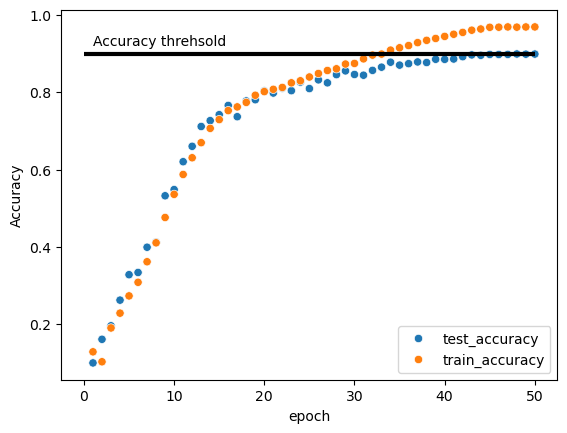

In [22]:
short_metrics_history_df = metrics_history_df.melt(id_vars=['epoch'], var_name='metric', value_name='value')
g = sns.scatterplot(data=short_metrics_history_df[short_metrics_history_df.metric.str.contains('accuracy')], x='epoch', y='value', hue='metric')
plt.hlines(xmin=0, xmax=short_metrics_history_df.epoch.max(), y=0.9, color='black', linewidth=3)
g.set_ylabel('Accuracy')
g.text(1, 0.92, 'Accuracy threhsold', color='black')
g.legend(loc='lower right')